In [2]:
from owslib.wms import WebMapService
wms = WebMapService('http://geo.pacioos.hawaii.edu/geoserver/PACIOOS_WMS_ONLY/hi_pacioos_all_whales/ows?service=WMS&version=1.3.0&request=GetCapabilities', version='1.3.0')
wms.identification.type
wms['hi_pacioos_all_whales'].boundingBoxWGS84
wms.identification.version
wms.identification.title
wms.identification.abstract
wms.contents
list(wms.contents)
wms['hi_pacioos_all_whales'].title
[op.name for op in wms.operations]
wms.getOperationByName('GetMap').methods
wms.getOperationByName('GetMap').formatOptions

['image/png',
 'application/atom+xml',
 'application/pdf',
 'application/vnd.google-earth.kml+xml',
 'application/vnd.google-earth.kml+xml;mode=networklink',
 'application/vnd.google-earth.kmz',
 'image/geotiff',
 'image/geotiff8',
 'image/gif',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/svg+xml',
 'image/tiff',
 'image/tiff8']

In [14]:
img_geotiff = wms.getmap( layers=['hi_pacioos_all_whales'], size=(500, 450), srs='EPSG:4326', bbox=wms['hi_pacioos_all_whales'].boundingBoxWGS84,format="image/geotiff")
#from IPython.display import Image
#Image(img.read())
out = open('pacioos_all_whales.tif', 'wb')
out.write(img_geotiff.read())
out.close()

In [24]:
import xarray as xr
from affine import Affine
da = xr.open_rasterio('pacioos_all_whales.tif')
transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file

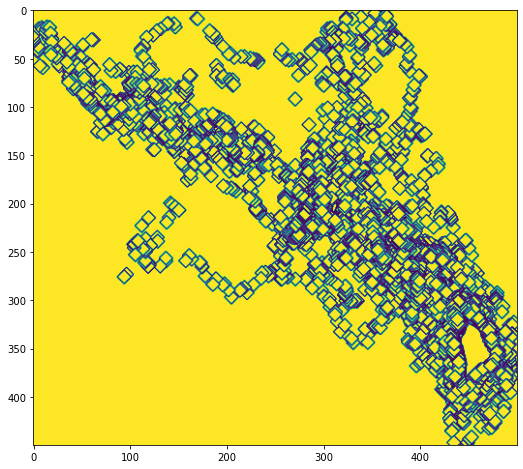

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(da.variable.data[0])
plt.show()

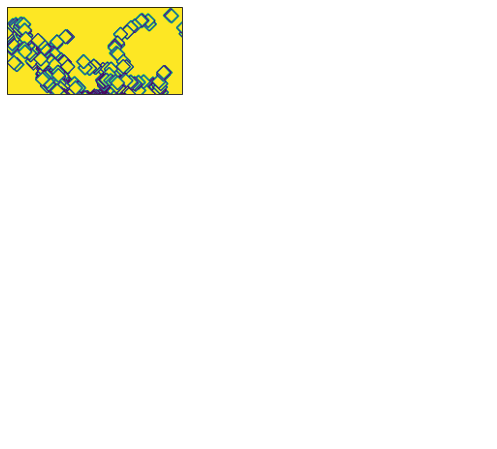

In [27]:
import cartopy.crs as ccrs
# Define the projection
crs=ccrs.PlateCarree()
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection=crs)
ax.imshow(da.variable.data[0])
plt.show()

<ipython-input-35-0fb539ced9de>:10: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  x, y = np.meshgrid(np.arange(nx), np.arange(ny)) * transform


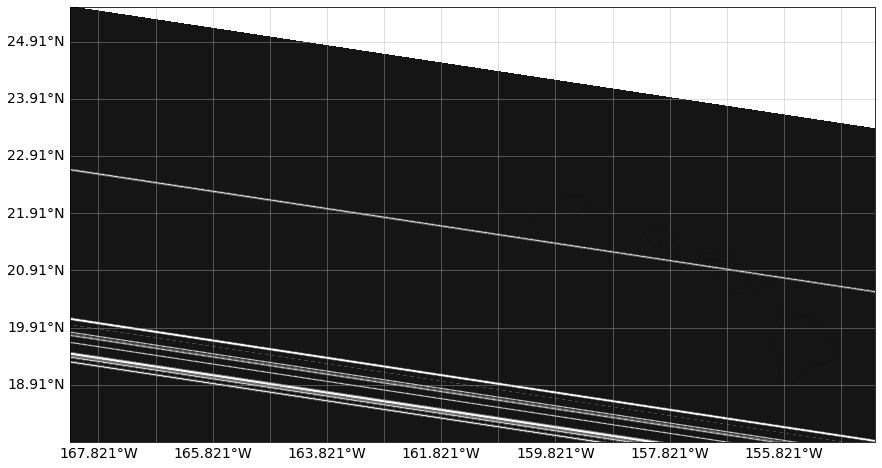

In [35]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import numpy as np

lon_min, lat_min, lon_max, lat_max = wms['hi_pacioos_all_whales'].boundingBoxWGS84

# Create meshgrid from geotiff
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx), np.arange(ny)) * transform

# Plot!
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection=crs)
ax.coastlines(resolution='10m', alpha=0.1)
ax.contourf(x, y, da.variable.data[0], cmap='Greys')
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Grid and Labels
gl = ax.gridlines(crs=crs, draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_right = None
xgrid = np.arange(lon_min-0.5, lon_max+.5, 1.)
ygrid = np.arange(lat_min, lat_max+1, 1.)
gl.xlocator = mticker.FixedLocator(xgrid.tolist())
gl.ylocator = mticker.FixedLocator(ygrid.tolist())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.show()

17.91

# Testing WMS with geopandas

In [1]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

# URL for WFS backend
url = "https://data.axds.co/gs/noaa_deepseacorals/wfs?service=WFS&version=1.0.0&request=GetFeature&outputFormat=application/json&typeName=noaa_deepseacorals:dsc_natdb"

# Initialize
wfs = WebFeatureService(url=url)

# Get data from WFS
# -----------------

# Fetch the last available layer (as an example) --> 'vaestoruutu:vaki2017_5km'
layer = list(wfs.contents)[-1]

# Specify the parameters for fetching the data
params = dict(service='WFS', version="1.0.0", request='GetFeature',
      typeName=layer, outputFormat='json')

# Parse the URL with parameters
q = Request('GET', url, params=params).prepare().url

# Read data from URL
data = gpd.read_file(q)

DriverError: '/vsimem/7264ef58c91b4d3c81d805fb8e91498f' not recognized as a supported file format.

In [18]:
import folium

url = 'https://data.axds.co/gs/mbon/wms?SERVICE=WMS&REQUEST=GetMap&LAYERS=mbon:event_occ_mof&VERSION=1.1.1&FORMAT=image/png'

m = folium.Map(width="100%", height="100%", location=[0,180], zoom_start=3)
w = folium.WmsTileLayer(
    url,
    name="Pacific Reef Assessment and Monitoring Program: Occurrence and Coverage",
    fmt="image/png",
    layers="mbon:event_occ_mof",
    style="boxfill/rainbow",
    COLORSCALERANGE="0,5",
    control=True,
    overlay=True,
    transparent=True,
    )
w.add_to(m)
folium.LayerControl().add_to(m)
m